Modelling travel behaviour of reduced-mobility pedestrians in a developing urban area using Machine Learning approaches

### Importing libraries

In [1]:
import pandas as pd
import numpy as np
from numpy import interp
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline
from tqdm import tqdm
import pickle
from pycaret.classification import *

#ignore log(0) and divide by 0 warning
np.seterr(divide = 'ignore');
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 


print('Libraries read!')

Libraries read!


### Reading the final dataset

In [2]:
base_dir = './'

In [5]:
merged_data = pd.read_csv(base_dir + 'df_corr.csv').iloc[:,1:]
#merged_data.drop(columns=['lat_o', 'lon_o', 'lat_d', 'lon_d'], axis=1, inplace=True)
print('Shape of merged_data:', merged_data.shape)
merged_data.head()

Shape of merged_data: (8791, 20)


,reason_trip,gender,schooling,occupation,work_dedication,laboral_sector,work_level,workplace,disability,household_income,type_home,type_ownership_house,stratum,freq_trip,main_mode,travel_time,age,num_cars,num_motorbikes,num_bikes
0,2,0,1,1,1,1,3,2,0,0,0,1,1,3,1,15.0,69.0,0,0,0
1,1,0,1,1,1,1,3,2,0,0,0,1,1,3,2,30.0,69.0,0,0,0
2,0,1,1,2,1,1,3,2,0,2,0,2,2,3,1,30.0,73.0,1,0,0
3,1,1,1,2,1,1,3,2,0,2,0,2,2,3,1,30.0,73.0,1,0,0
4,2,1,1,2,1,1,3,2,0,0,1,0,2,3,2,5.0,80.0,0,0,0


# Feature Engineering

In [6]:
merged_data['main_mode'].value_counts()

2    4300
1    3250
0    1241
Name: main_mode, dtype: int64

In [7]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8791 entries, 0 to 8790
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   reason_trip           8791 non-null   int64  
 1   gender                8791 non-null   int64  
 2   schooling             8791 non-null   int64  
 3   occupation            8791 non-null   int64  
 4   work_dedication       8791 non-null   int64  
 5   laboral_sector        8791 non-null   int64  
 6   work_level            8791 non-null   int64  
 7   workplace             8791 non-null   int64  
 8   disability            8791 non-null   int64  
 9   household_income      8791 non-null   int64  
 10  type_home             8791 non-null   int64  
 11  type_ownership_house  8791 non-null   int64  
 12  stratum               8791 non-null   int64  
 13  freq_trip             8791 non-null   int64  
 14  main_mode             8791 non-null   int64  
 15  travel_time          

In [8]:
merged_data.describe(include='all')

,reason_trip,gender,schooling,occupation,work_dedication,laboral_sector,work_level,workplace,disability,household_income,type_home,type_ownership_house,stratum,freq_trip,main_mode,travel_time,age,num_cars,num_motorbikes,num_bikes
count,8791.000000,8791.000000,8791.000000,8791.000000,8791.000000,8791.000000,8791.000000,8791.000000,8791.000000,8791.000000,8791.000000,8791.000000,8791.000000,8791.000000,8791.000000,8791.000000,8791.000000,8791.000000,8791.000000,8791.000000
mean,2.367080,0.529405,0.973837,1.341258,0.942100,1.125242,2.702992,1.832784,0.204755,0.917074,0.691389,1.174838,1.327494,1.201797,1.347970,29.511432,68.157434,0.245706,0.144807,0.054033
std,2.040724,0.499163,0.435613,0.829917,0.463151,0.505387,0.698732,0.474874,0.403545,1.132142,0.473140,0.476319,0.652129,1.306238,0.713638,22.462515,12.963974,0.526788,0.420826,0.295459
min,0.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,3.000000,2.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,10.000000,66.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,3.000000,2.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,25.000000,70.000000,0.000000,0.000000,0.000000
75%,4.000000,1.000000,1.000000,2.000000,1.000000,1.000000,3.000000,2.000000,0.000000,2.000000,1.000000,1.000000,2.000000,3.000000,2.000000,40.000000,75.000000,0.000000,0.000000,0.000000
max,7.000000,1.000000,2.000000,3.000000,2.000000,3.000000,3.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,3.000000,2.000000,120.000000,99.000000,5.000000,4.000000,4.000000


In [9]:
merged_data.head()

,reason_trip,gender,schooling,occupation,work_dedication,laboral_sector,work_level,workplace,disability,household_income,type_home,type_ownership_house,stratum,freq_trip,main_mode,travel_time,age,num_cars,num_motorbikes,num_bikes
0,2,0,1,1,1,1,3,2,0,0,0,1,1,3,1,15.0,69.0,0,0,0
1,1,0,1,1,1,1,3,2,0,0,0,1,1,3,2,30.0,69.0,0,0,0
2,0,1,1,2,1,1,3,2,0,2,0,2,2,3,1,30.0,73.0,1,0,0
3,1,1,1,2,1,1,3,2,0,2,0,2,2,3,1,30.0,73.0,1,0,0
4,2,1,1,2,1,1,3,2,0,0,1,0,2,3,2,5.0,80.0,0,0,0


In [10]:
merged_data.isnull().sum()

reason_trip             0
gender                  0
schooling               0
occupation              0
work_dedication         0
laboral_sector          0
work_level              0
workplace               0
disability              0
household_income        0
type_home               0
type_ownership_house    0
stratum                 0
freq_trip               0
main_mode               0
travel_time             0
age                     0
num_cars                0
num_motorbikes          0
num_bikes               0
dtype: int64

# PYCARET

In [11]:
# Importing module and initialising setup

classifier_merged_data = setup(data = merged_data,
                               target = 'main_mode',
                               session_id = 42,
                               normalize = True,
                               #combine_rare_levels = True,
                               #rare_level_threshold = 0.05,
                               #remove_multicollinearity = True,
                               #multicollinearity_threshold = 0.80,
                               use_gpu = True,
                               #remove_outliers = True,
                               #outliers_threshold = 0.1,
                               #fix_imbalance = True,
                               data_split_stratify = True,
                               fold_strategy = 'stratifiedkfold'
                               )

,Description,Value
0,session_id,42
1,Target,main_mode
2,Target Type,Multiclass
3,Label Encoded,"0: 0, 1: 1, 2: 2"
4,Original Data,"(8791, 20)"
5,Missing Values,False
6,Numeric Features,2
7,Categorical Features,17
8,Ordinal Features,False
9,High Cardinality Features,False


# Machine Learning models

In [10]:
best_models = compare_models(sort='AUC', turbo=False) 

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.7928,0.9087,0.7716,0.7929,0.7922,0.6553,0.6558,6.1530
rf,Random Forest Classifier,0.7993,0.9080,0.7839,0.7997,0.7988,0.6661,0.6667,0.9900
lightgbm,Light Gradient Boosting Machine,0.7811,0.9029,0.7640,0.7814,0.7808,0.6371,0.6376,0.2500
et,Extra Trees Classifier,0.7830,0.8903,0.7709,0.7836,0.7826,0.6395,0.6401,1.1280
gbc,Gradient Boosting Classifier,0.7476,0.8823,0.7231,0.7491,0.7477,0.5828,0.5834,2.5290
mlp,MLP Classifier,0.7497,0.8750,0.7221,0.7488,0.7485,0.5827,0.5834,14.0120
gpc,Gaussian Process Classifier,0.7757,0.8671,0.7365,0.7764,0.7733,0.6210,0.6232,97.1300
rbfsvm,SVM - Radial Kernel,0.7253,0.8654,0.7033,0.7277,0.7252,0.5469,0.5480,11.8670
knn,K Neighbors Classifier,0.7369,0.8624,0.7033,0.7355,0.7351,0.5597,0.5606,0.5650
lr,Logistic Regression,0.7257,0.8616,0.6878,0.7244,0.7236,0.5410,0.5424,1.3710


# Catboost Classifier

In [11]:
# Best ML analysis
catboost = create_model(estimator = 'catboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7825,0.9050,0.7665,0.7806,0.7806,0.6375,0.6386
1,0.7922,0.9135,0.7714,0.7927,0.7924,0.6568,0.6568
2,0.7971,0.9082,0.7574,0.7959,0.7956,0.6604,0.6609
3,0.7756,0.8948,0.7522,0.7762,0.7754,0.6256,0.6258
4,0.7984,0.9080,0.7615,0.7976,0.7968,0.6609,0.6618
5,0.8146,0.9191,0.8039,0.8146,0.8146,0.6935,0.6935
6,0.7837,0.9021,0.7626,0.7826,0.7829,0.6396,0.6399
7,0.7919,0.9134,0.7696,0.7913,0.7909,0.6519,0.6526
8,0.8179,0.9246,0.8025,0.8182,0.8179,0.6975,0.6976
9,0.7740,0.8984,0.7685,0.7793,0.7752,0.6294,0.6310


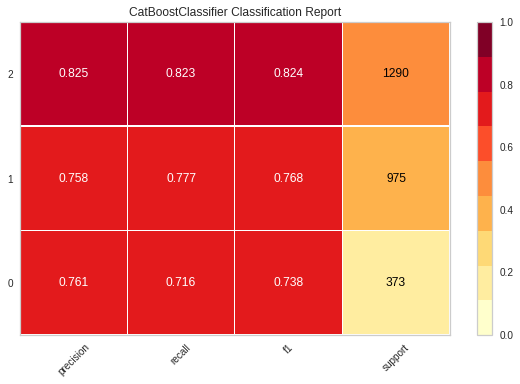

In [12]:
# Plotting the classification report
plot_model(estimator = catboost, plot = 'class_report')

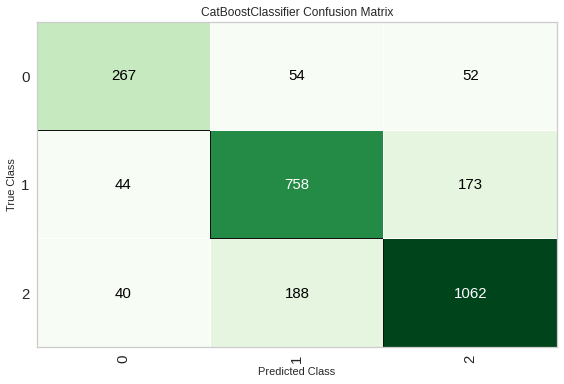

In [13]:
# Plotting the confusion matrix
plot_model(estimator = catboost, plot = 'confusion_matrix')

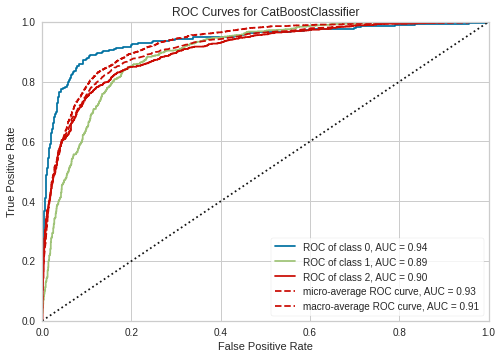

In [14]:
# Plotting the AUC
plot_model(estimator = catboost, plot = 'auc')

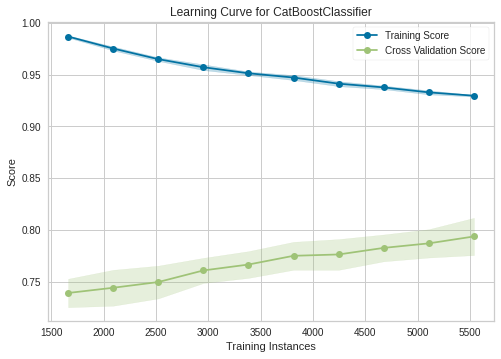

In [15]:
# Plotting the learning curve
plot_model(estimator = catboost, plot = 'learning' )

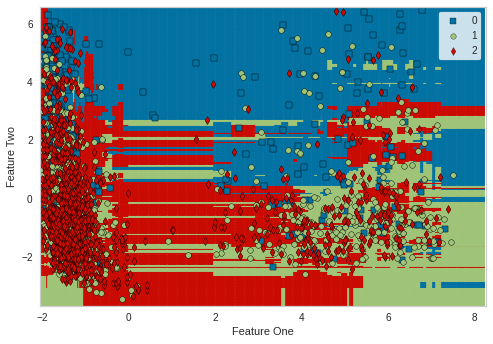

In [16]:
plot_model(estimator = catboost, plot='boundary')

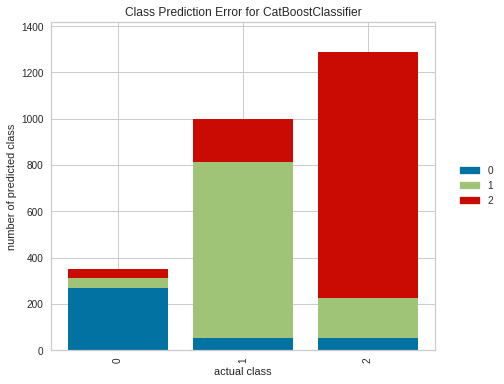

In [17]:
plot_model(estimator = catboost, plot = 'error')

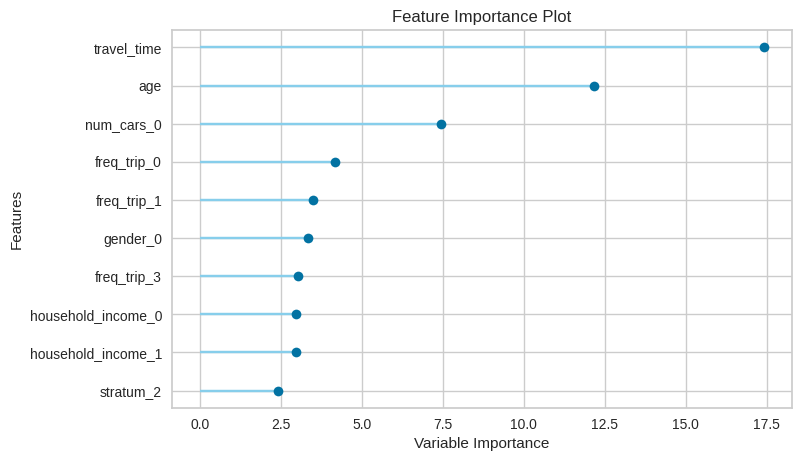

In [18]:
# Plotting the feature importance
plot_model(estimator = catboost, plot = 'feature')

In [19]:
evaluate_model(estimator = catboost)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

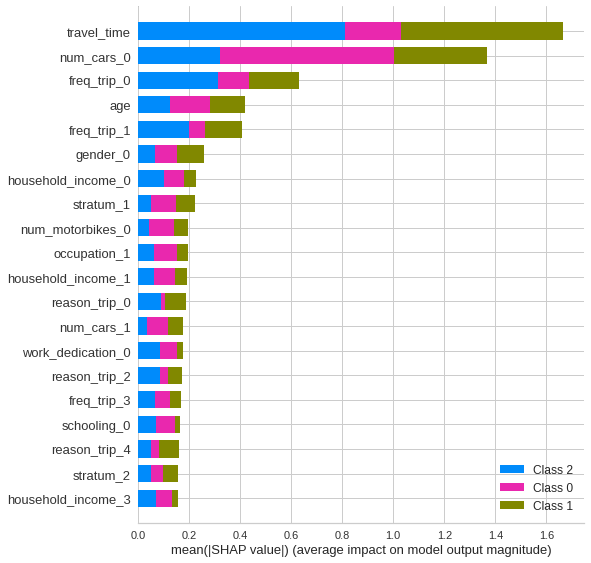

In [20]:
interpret_model(estimator = catboost)

In [21]:
predict_model(estimator = catboost)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.7911,0.9047,0.7722,0.7912,0.7910,0.6533,0.6534


,travel_time,age,reason_trip_0,reason_trip_1,reason_trip_2,reason_trip_3,reason_trip_4,reason_trip_5,reason_trip_6,reason_trip_7,...,num_motorbikes_3,num_motorbikes_4,num_bikes_0,num_bikes_1,num_bikes_2,num_bikes_3,num_bikes_4,main_mode,Label,Score
0,0.022008,0.129720,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1,0.5429
1,0.022008,0.129720,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0.8575
2,-0.423736,0.902465,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2,2,0.8418
3,1.359243,-0.179378,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1,0.9763
4,0.022008,-2.420337,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1,0.9448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2633,-1.092354,0.593367,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2,2,0.9857
2634,0.022008,0.670641,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1,0.6410
2635,1.359243,-0.179378,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1,0.8826
2636,1.359243,0.206995,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1,0.9173


# Tuned model: catboost

In [22]:
# tune hyperparameters to optimize AUC
tuned_catboost = tune_model(catboost, optimize = 'AUC', n_iter=80)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7695,0.9011,0.7467,0.7678,0.7677,0.6141,0.6150
1,0.8019,0.9177,0.7916,0.8023,0.8021,0.6732,0.6732
2,0.7987,0.9149,0.7538,0.7970,0.7970,0.6633,0.6638
3,0.7707,0.8932,0.7510,0.7723,0.7707,0.6164,0.6167
4,0.7967,0.9086,0.7670,0.7968,0.7954,0.6579,0.6590
5,0.8065,0.9164,0.8001,0.8062,0.8063,0.6795,0.6796
6,0.7870,0.9066,0.7632,0.7860,0.7862,0.6453,0.6456
7,0.7919,0.9173,0.7696,0.7910,0.7911,0.6532,0.6536
8,0.8228,0.9260,0.8062,0.8234,0.8227,0.7047,0.7050
9,0.7870,0.9010,0.7780,0.7912,0.7881,0.6503,0.6514


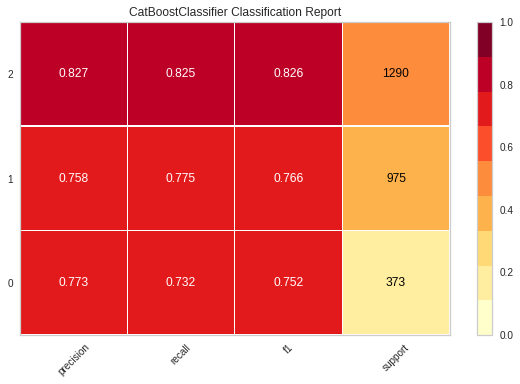

In [23]:
# Plotting the classification report
plot_model(estimator = tuned_catboost, plot = 'class_report')

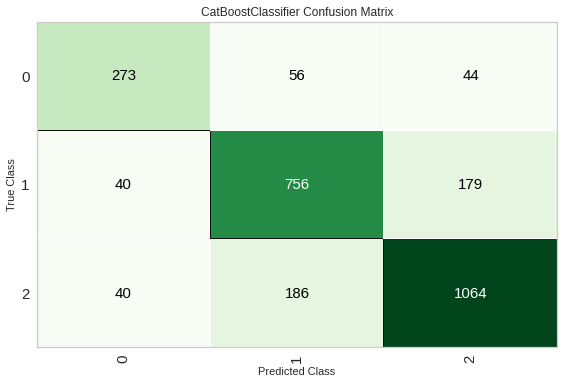

In [24]:
# Plotting the confusion matrix
plot_model(estimator = tuned_catboost, plot = 'confusion_matrix')

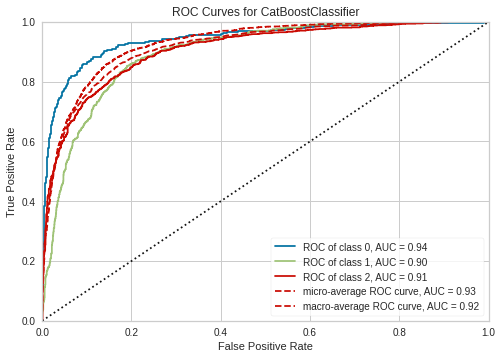

In [25]:
# Plotting the AUC
plot_model(estimator = tuned_catboost, plot = 'auc')

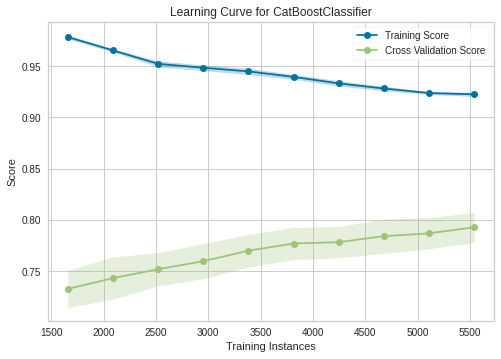

In [26]:
# Plotting the learning curve
plot_model(estimator = tuned_catboost, plot = 'learning' )

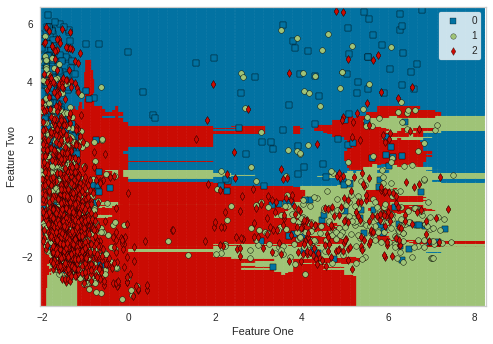

In [27]:
plot_model(estimator = tuned_catboost, plot='boundary')

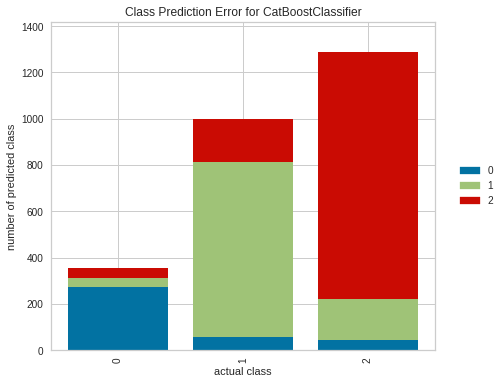

In [28]:
plot_model(estimator = tuned_catboost, plot = 'error')

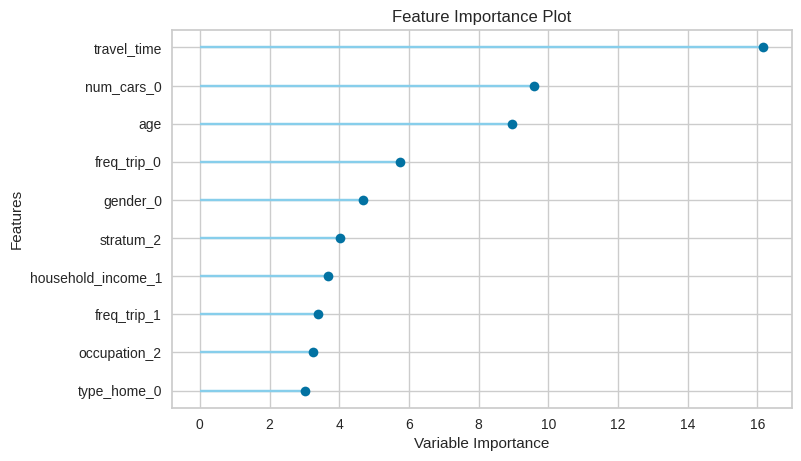

In [29]:
# Plotting the feature importance
plot_model(estimator = tuned_catboost, plot = 'feature')

In [30]:
evaluate_model(estimator = tuned_catboost)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

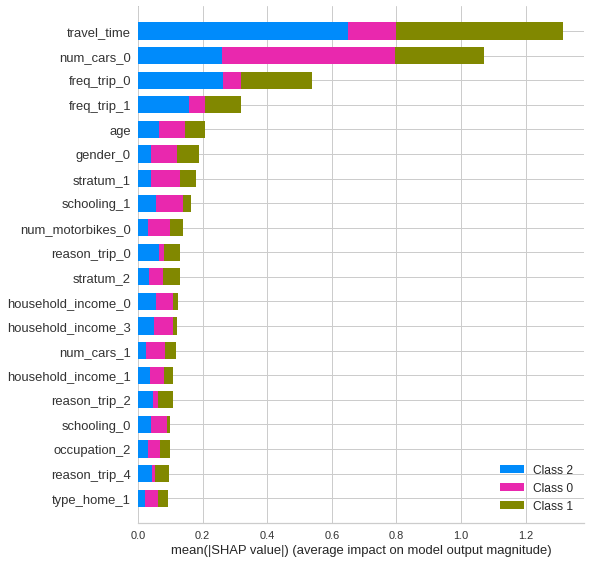

In [31]:
interpret_model(estimator = tuned_catboost)

In [32]:
predict_model(estimator = tuned_catboost)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.7934,0.9083,0.7774,0.7936,0.7934,0.6572,0.6573


,travel_time,age,reason_trip_0,reason_trip_1,reason_trip_2,reason_trip_3,reason_trip_4,reason_trip_5,reason_trip_6,reason_trip_7,...,num_motorbikes_3,num_motorbikes_4,num_bikes_0,num_bikes_1,num_bikes_2,num_bikes_3,num_bikes_4,main_mode,Label,Score
0,0.022008,0.129720,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1,0.7688
1,0.022008,0.129720,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0.6767
2,-0.423736,0.902465,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2,2,0.7891
3,1.359243,-0.179378,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1,0.9126
4,0.022008,-2.420337,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1,0.8361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2633,-1.092354,0.593367,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2,2,0.9523
2634,0.022008,0.670641,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,0,0.5310
2635,1.359243,-0.179378,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1,0.7932
2636,1.359243,0.206995,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1,0.8966


# Random Forest Classifier

In [33]:
# Best ML analysis
rf = create_model(estimator = 'rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7857,0.9015,0.7698,0.7850,0.7841,0.6409,0.6422
1,0.7955,0.9065,0.7977,0.7981,0.7960,0.6654,0.6658
2,0.8084,0.9082,0.7784,0.8078,0.8075,0.6798,0.6802
3,0.7854,0.8900,0.7692,0.7854,0.7851,0.6417,0.6419
4,0.8016,0.9078,0.7786,0.8018,0.8006,0.6676,0.6689
5,0.8163,0.9243,0.8109,0.8164,0.8163,0.6949,0.6949
6,0.7854,0.9091,0.7661,0.7845,0.7843,0.6415,0.6421
7,0.7951,0.9130,0.7694,0.7946,0.7940,0.6568,0.6576
8,0.8325,0.9258,0.8143,0.8324,0.8323,0.7219,0.7219
9,0.7870,0.8935,0.7848,0.7907,0.7881,0.6505,0.6513


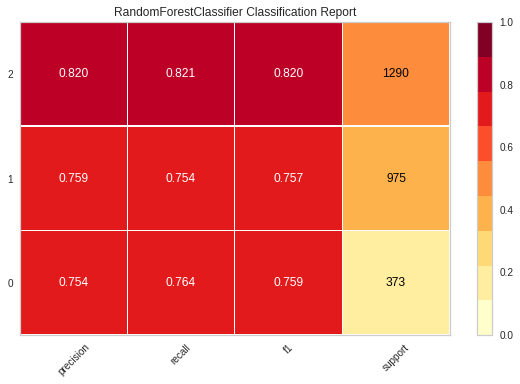

In [34]:
# Plotting the classification report
plot_model(estimator = rf, plot = 'class_report')

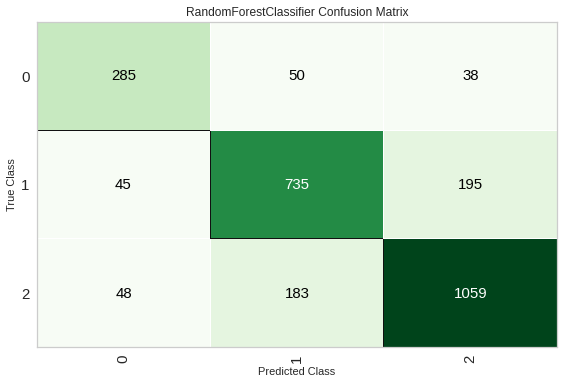

In [35]:
# Plotting the confusion matrix
plot_model(estimator = rf, plot = 'confusion_matrix')

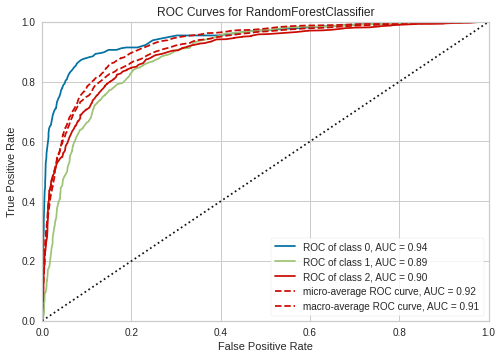

In [36]:
# Plotting the AUC
plot_model(estimator = rf, plot = 'auc')

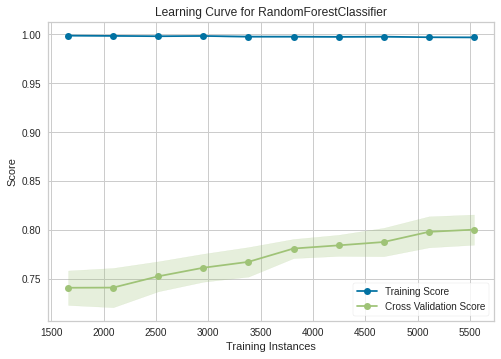

In [37]:
# Plotting the learning curve
plot_model(estimator = rf, plot = 'learning' )

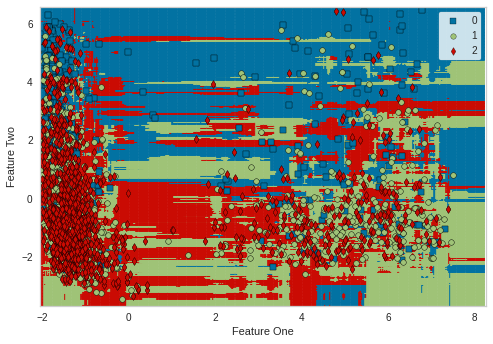

In [38]:
plot_model(estimator = rf, plot='boundary')

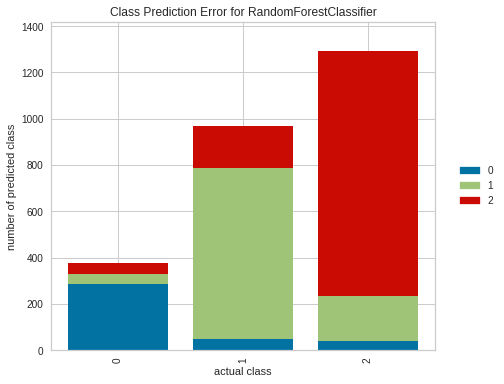

In [39]:
plot_model(estimator = rf, plot = 'error')

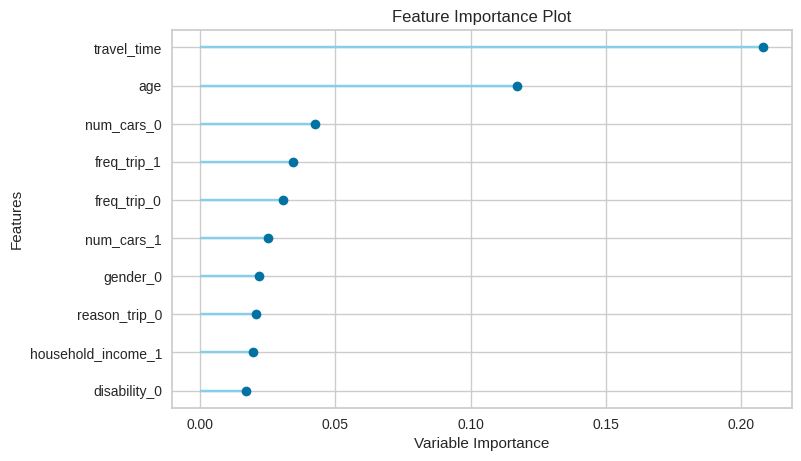

In [40]:
# Plotting the feature importance
plot_model(estimator = rf, plot = 'feature')

In [41]:
evaluate_model(estimator = rf)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

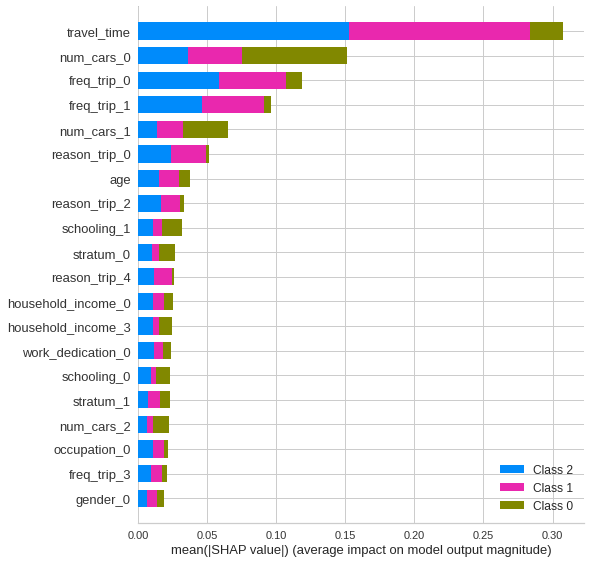

In [42]:
interpret_model(estimator = rf)

In [43]:
predict_model(estimator = rf)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.7881,0.9030,0.7796,0.7881,0.7881,0.6495,0.6495


,travel_time,age,reason_trip_0,reason_trip_1,reason_trip_2,reason_trip_3,reason_trip_4,reason_trip_5,reason_trip_6,reason_trip_7,...,num_motorbikes_3,num_motorbikes_4,num_bikes_0,num_bikes_1,num_bikes_2,num_bikes_3,num_bikes_4,main_mode,Label,Score
0,0.022008,0.129720,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1,0.80
1,0.022008,0.129720,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0.79
2,-0.423736,0.902465,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2,2,0.88
3,1.359243,-0.179378,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1,0.82
4,0.022008,-2.420337,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1,0.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2633,-1.092354,0.593367,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2,2,0.95
2634,0.022008,0.670641,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,0,0.43
2635,1.359243,-0.179378,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1,0.78
2636,1.359243,0.206995,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1,0.92


# Tuned model: rf

In [44]:
# tune hyperparameters to optimize AUC
tuned_rf = tune_model(rf, optimize = 'AUC', n_iter=80)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7468,0.8843,0.7346,0.7456,0.7458,0.5810,0.5814
1,0.7549,0.8965,0.7458,0.7588,0.7562,0.5992,0.5997
2,0.7857,0.9048,0.7582,0.7875,0.7863,0.6467,0.6472
3,0.7366,0.8711,0.6975,0.7368,0.7354,0.5580,0.5586
4,0.7593,0.8900,0.7266,0.7581,0.7585,0.5986,0.5987
5,0.7659,0.8951,0.7515,0.7670,0.7663,0.6141,0.6142
6,0.7545,0.8858,0.7338,0.7549,0.7547,0.5938,0.5938
7,0.7821,0.8949,0.7578,0.7814,0.7815,0.6369,0.6371
8,0.7935,0.9082,0.7663,0.7928,0.7926,0.6549,0.6552
9,0.7317,0.8671,0.7079,0.7365,0.7325,0.5583,0.5600


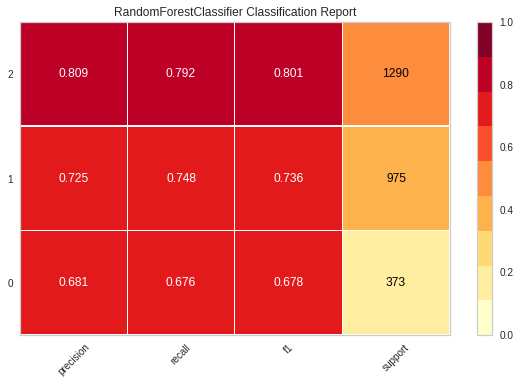

In [45]:
# Plotting the classification report
plot_model(estimator = tuned_rf, plot = 'class_report')

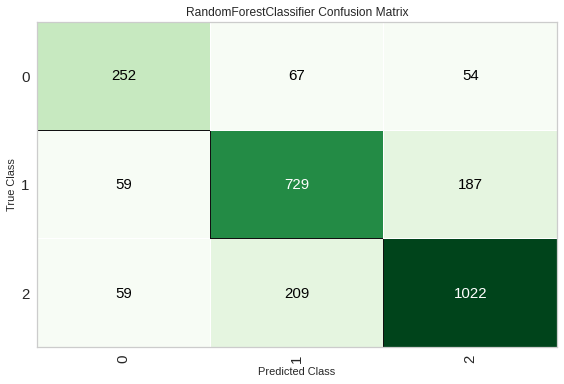

In [46]:
# Plotting the confusion matrix
plot_model(estimator = tuned_rf, plot = 'confusion_matrix')

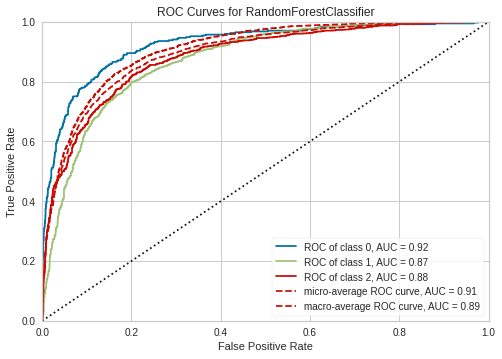

In [47]:
# Plotting the AUC
plot_model(estimator = tuned_rf, plot = 'auc')

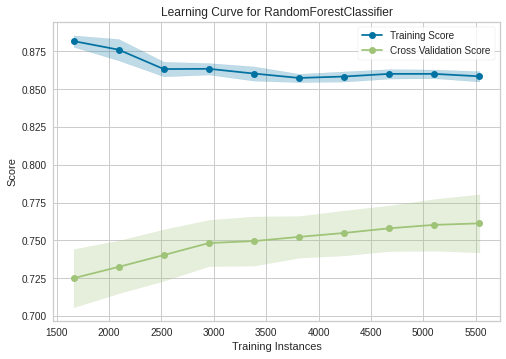

In [48]:
# Plotting the learning curve
plot_model(estimator = tuned_rf, plot = 'learning' )

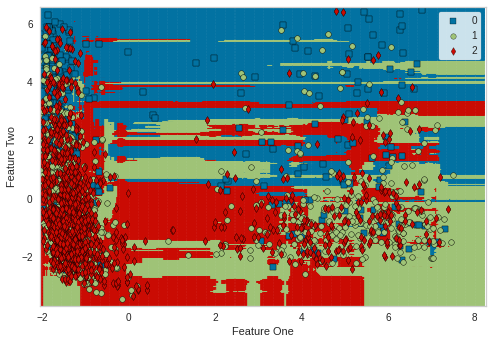

In [49]:
plot_model(estimator = tuned_rf, plot='boundary')

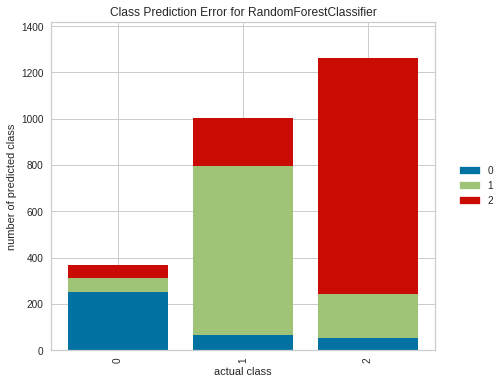

In [50]:
plot_model(estimator = tuned_rf, plot = 'error')

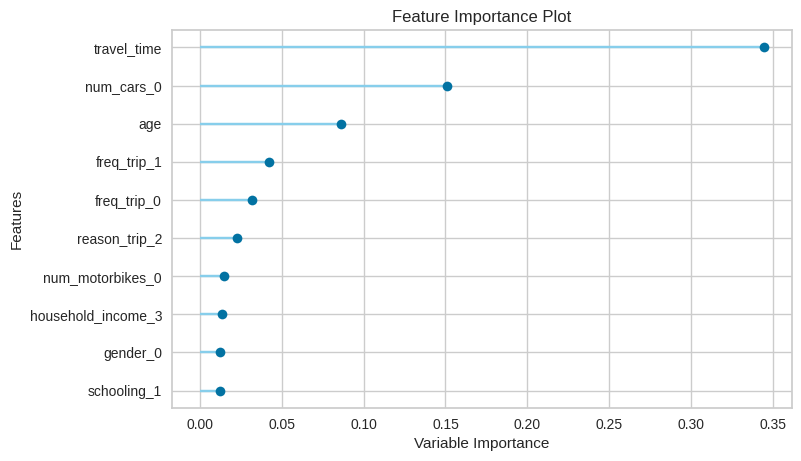

In [51]:
# Plotting the feature importance
plot_model(estimator = tuned_rf, plot = 'feature')

In [52]:
evaluate_model(estimator = tuned_rf)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

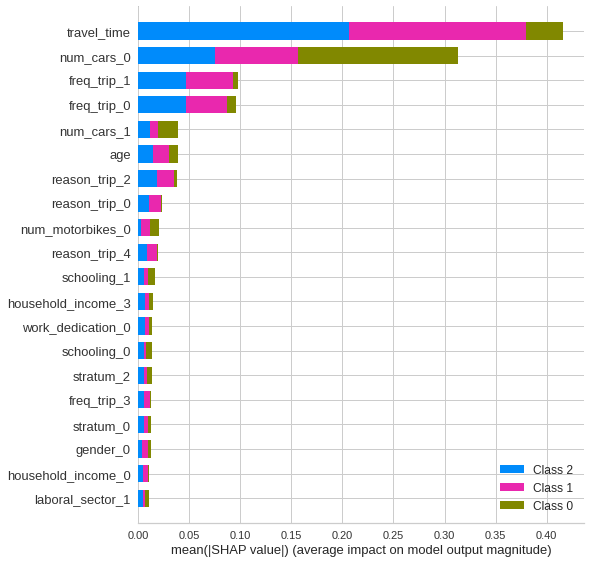

In [53]:
interpret_model(estimator = tuned_rf)

In [54]:
predict_model(estimator = tuned_rf)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.7593,0.8854,0.7385,0.7601,0.7596,0.6023,0.6024


,travel_time,age,reason_trip_0,reason_trip_1,reason_trip_2,reason_trip_3,reason_trip_4,reason_trip_5,reason_trip_6,reason_trip_7,...,num_motorbikes_3,num_motorbikes_4,num_bikes_0,num_bikes_1,num_bikes_2,num_bikes_3,num_bikes_4,main_mode,Label,Score
0,0.022008,0.129720,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1,0.7201
1,0.022008,0.129720,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0.8432
2,-0.423736,0.902465,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2,2,0.6852
3,1.359243,-0.179378,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1,0.8435
4,0.022008,-2.420337,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1,0.7844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2633,-1.092354,0.593367,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2,2,0.9414
2634,0.022008,0.670641,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,0,0.6013
2635,1.359243,-0.179378,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1,0.7974
2636,1.359243,0.206995,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1,0.8796


# Saving the models

In [55]:
# CatBoostClassifier Model
catboost_model = 'catboost_model.sav'
pickle.dump(catboost, open(base_dir + catboost_model, 'wb')) # Just save the model once

In [56]:
# tuned CatBoostClassifier Model
tuned_catboost_model = 'tuned_catboost_model.sav'
pickle.dump(tuned_catboost, open(base_dir + tuned_catboost_model, 'wb')) # Just save the model once

In [57]:
# RandomForestClassifier Model
rf_model = 'rf_model.sav'
pickle.dump(rf, open(base_dir + rf_model, 'wb')) # Just save the model once

In [58]:
# tuned RandomForestClassifier Model
tuned_rf_model = 'tuned_rf_model.sav'
pickle.dump(tuned_rf, open(base_dir + tuned_rf_model, 'wb')) # Just save the model once

In [76]:
for i,j in enumerate(classifier_merged_data):
    print(i)
    print(j)
    print('________________')

0
      reason_trip  gender  schooling  occupation  work_dedication  \
0               2       0          1           1                1   
1               1       0          1           1                1   
2               0       1          1           2                1   
3               1       1          1           2                1   
4               2       1          1           2                1   
...           ...     ...        ...         ...              ...   
8786            1       1          1           0                0   
8787            7       1          1           2                1   
8788            1       1          1           2                1   
8789            4       0          1           1                1   
8790            1       0          1           1                1   

      laboral_sector  work_level  workplace  disability  household_income  \
0                  1           3          2           0                 0   
1              

In [71]:
training_set = classifier_merged_data[18]
training_set[['travel_time', 'num_cars_0', 'num_cars_1', 'num_cars_2', 'num_cars_3', 'num_cars_5', 
              'num_motorbikes_0', 'num_motorbikes_1', 'num_motorbikes_2', 'num_motorbikes_3', 'num_motorbikes_4',
              'freq_trip_0', 'freq_trip_1', 'freq_trip_2', 'freq_trip_3']].describe(include='all')

,travel_time,num_cars_0,num_cars_1,num_cars_2,num_cars_3,num_cars_5,num_motorbikes_0,num_motorbikes_1,num_motorbikes_2,num_motorbikes_3,num_motorbikes_4,freq_trip_0,freq_trip_1,freq_trip_2,freq_trip_3
count,6.153000e+03,6153.000000,6153.000000,6153.000000,6153.000000,6153.000000,6153.000000,6153.000000,6153.000000,6153.000000,6153.000000,6153.000000,6153.000000,6153.000000,6153.000000
mean,-6.199735e-09,0.794572,0.173086,0.027791,0.004226,0.000325,0.875508,0.101902,0.020478,0.001788,0.000325,0.459126,0.191126,0.033155,0.316594
std,1.000081e+00,0.404047,0.378353,0.164388,0.064872,0.018028,0.330169,0.302543,0.141639,0.042247,0.018028,0.498367,0.393220,0.179055,0.465185
min,-1.270652e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-8.694814e-01,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-2.008641e-01,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.677532e-01,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,4.033712e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [72]:
test_set = classifier_merged_data[1]
test_set[['travel_time', 'num_cars_0', 'num_cars_1', 'num_cars_2', 'num_cars_3', 'num_cars_5', 
              'num_motorbikes_0', 'num_motorbikes_1', 'num_motorbikes_2', 'num_motorbikes_3', 'num_motorbikes_4',
              'freq_trip_0', 'freq_trip_1', 'freq_trip_2', 'freq_trip_3']].describe(include='all')

,travel_time,num_cars_0,num_cars_1,num_cars_2,num_cars_3,num_cars_5,num_motorbikes_0,num_motorbikes_1,num_motorbikes_2,num_motorbikes_3,num_motorbikes_4,freq_trip_0,freq_trip_1,freq_trip_2,freq_trip_3
count,2638.000000,2638.000000,2638.000000,2638.000000,2638.000000,2638.000000,2638.000000,2638.000000,2638.000000,2638.000000,2638.0,2638.000000,2638.000000,2638.000000,2638.000000
mean,0.000769,0.790751,0.172858,0.031463,0.004170,0.000758,0.888552,0.090599,0.019333,0.001516,0.0,0.461334,0.191812,0.043215,0.303639
std,1.004177,0.406850,0.378196,0.174599,0.064452,0.027529,0.314746,0.287092,0.137718,0.038918,0.0,0.498597,0.393801,0.203378,0.459916
min,-1.270652,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,-0.769189,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
50%,-0.200864,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
75%,0.467753,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,1.000000
max,4.033712,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000


In [86]:
training_target = classifier_merged_data[14][2][1]
training_target.value_counts(normalize=True)

2    0.489192
1    0.369738
0    0.141069
Name: main_mode, dtype: float64

In [80]:
test_target = classifier_merged_data[2]
test_target.value_counts(normalize=True)

2    0.489007
1    0.369598
0    0.141395
Name: main_mode, dtype: float64